In [1]:
import os
import json
import random
import helper
import models
import pickle
import numpy as np
import pandas as pd
import importlib as imp
from datetime import datetime
from matplotlib import pyplot as plt
from __future__ import print_function

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets, transforms, utils

rs = 2018
random.seed(rs)

pd.options.display.max_rows = 500
pd.options.display.max_columns = 500
pd.options.display.width = 1000

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
use_cuda = torch.cuda.is_available()
print('Using cuda: {}'.format(use_cuda))
torch.manual_seed(rs)
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
batch_size = 100

Using cuda: False


In [3]:
train_loader = torch.utils.data.DataLoader(
    datasets.EMNIST('data/', train=True, split='digits', download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.EMNIST('data/', train=False, split='digits', transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True, **kwargs)

test_loader_ordered = torch.utils.data.DataLoader(
    datasets.EMNIST('data/', train=False, split='digits', transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=len(test_loader.dataset), shuffle=False, **kwargs)

In [4]:
fours = np.load('files_for_comparison/digits4.npz')
sevens = np.load('files_for_comparison/digits7.npz')
eights = np.load('files_for_comparison/digits8.npz')

indices = {
    4: {
        'ix1':fours['ix1'],
        'ix2':fours['ix2']
    },
    7: {
        'ix1':sevens['ix1'],
        'ix2':sevens['ix2']
    },
    8: {
        'ix1':eights['ix1'],
        'ix2':eights['ix2']
    }
}

In [5]:
testiter = iter(test_loader_ordered)
images, target = testiter.next()
images = helper.rotate(images, cuda=use_cuda)

ix4_1 = torch.LongTensor(indices[4]['ix1'])
ix4_2 = torch.LongTensor(indices[4]['ix2'])
ix7_1 = torch.LongTensor(indices[7]['ix1'])
ix7_2 = torch.LongTensor(indices[7]['ix2'])
ix8_1 = torch.LongTensor(indices[8]['ix1'])
ix8_2 = torch.LongTensor(indices[8]['ix2'])

im4_1 = images[ix4_1]
im4_2 = images[ix4_2]
im7_1 = images[ix7_1]
im7_2 = images[ix7_2]
im8_1 = images[ix8_1]
im8_2 = images[ix8_2]


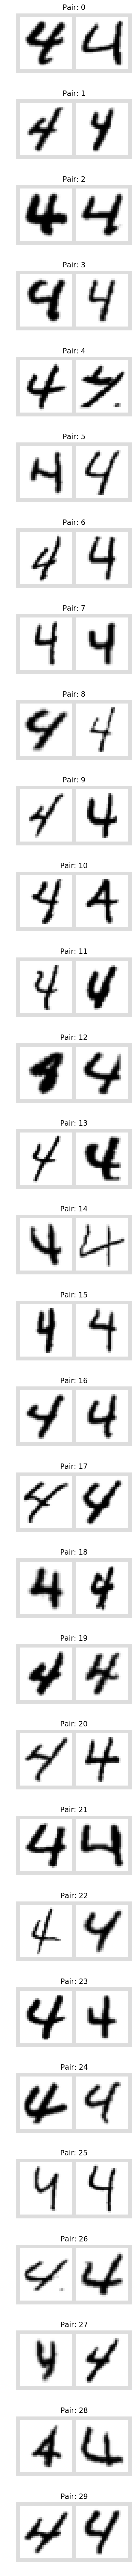

In [6]:
helper.plot_image_pairs(im4_1, im4_2)

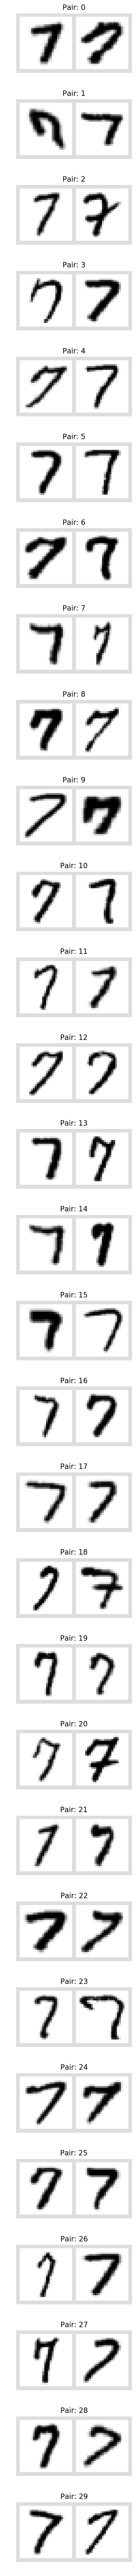

In [7]:
helper.plot_image_pairs(im7_1, im7_2)

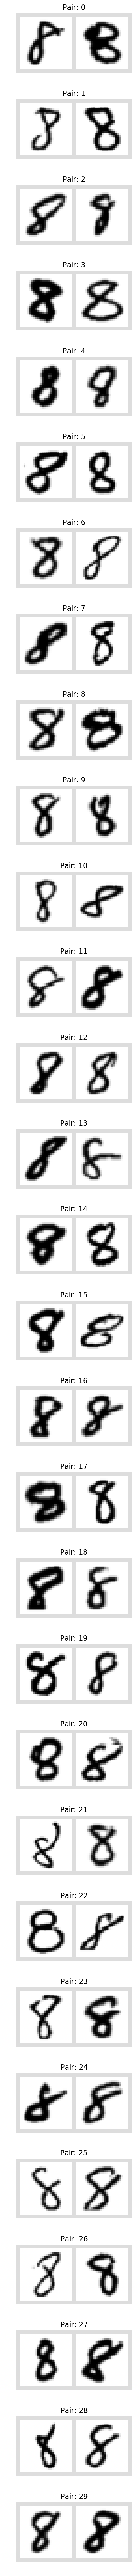

In [8]:
helper.plot_image_pairs(im8_1, im8_2)

In [9]:
data_df = pd.read_csv('results/pytorch_results.csv')
print(data_df.columns.tolist())
for l in range(1,5):
    print(data_df[data_df.layers==l].sort_values(by='accuracy', ascending=False).head(1).values[0].tolist())

['batch_size', 'layers', 'dropout_rate', 'n_filters', 'filter_size', 'fc_units', 'epoch', 'train_time', 'test_loss', 'accuracy']
[100, 1, 0.2, 10, 5, 100, 15, '0 days 00:12:48.673449000', 0.03253963649272919, 0.9903]
[100, 2, 0.2, 16, 5, 50, 15, '0 days 00:12:42.133719000', 0.02724303795993328, 0.991825]
[100, 3, 0.2, 16, 5, 50, 15, '0 days 00:12:47.853331000', 0.027311920815706246, 0.99185]
[100, 4, 0.2, 16, 5, 100, 15, '0 days 00:13:31.713766000', 0.026011360847949985, 0.9924]


In [10]:
args = {1: {'dropout_rate':0.2, 'n_filters':10, 'filter_size':5, 'fc_units':100, 'epoch':15},
       2: {'dropout_rate':0.2, 'n_filters':16, 'filter_size':5, 'fc_units':50, 'epoch':15},
       3: {'dropout_rate':0.2, 'n_filters':16, 'filter_size':5, 'fc_units':50, 'epoch':15},
       4: {'dropout_rate':0.2, 'n_filters':16, 'filter_size':5, 'fc_units':100, 'epoch':15},
      }

Net1 = models.get_model(1,
                        dropout_rate=args[1]['dropout_rate'],
                        n_filters=args[1]['n_filters'],
                        filter_size=args[1]['filter_size'],
                        fc_units=args[1]['fc_units'])
Net1.load_state_dict(torch.load('best_models/CNN_'+str(1)+'_layers', map_location='cpu'))

Net2 = models.get_model(2,
                        dropout_rate=args[2]['dropout_rate'],
                        n_filters=args[2]['n_filters'],
                        filter_size=args[2]['filter_size'],
                        fc_units=args[2]['fc_units'])
Net2.load_state_dict(torch.load('best_models/CNN_'+str(2)+'_layers', map_location='cpu'))

Net3 = models.get_model(3,
                        dropout_rate=args[3]['dropout_rate'],
                        n_filters=args[3]['n_filters'],
                        filter_size=args[3]['filter_size'],
                        fc_units=args[3]['fc_units'])
Net3.load_state_dict(torch.load('best_models/CNN_'+str(3)+'_layers', map_location='cpu'))

Net4 = models.get_model(4,
                        dropout_rate=args[4]['dropout_rate'],
                        n_filters=args[4]['n_filters'],
                        filter_size=args[4]['filter_size'],
                        fc_units=args[4]['fc_units'])
Net4.load_state_dict(torch.load('best_models/CNN_'+str(4)+'_layers', map_location='cpu'))

In [11]:
humans4 = np.zeros((7,30))
humans7 = np.zeros((7,30))
humans8 = np.zeros((7,30))
for ix, f in enumerate(os.listdir('human_ratings/')):
    df = pd.read_csv('human_ratings/'+f, skiprows=1)
    humans4[ix] = df['4'].values
    humans7[ix] = df['7'].values
    humans8[ix] = df['8'].values
    
avg4 = humans4.mean(axis=0)
avg7 = humans7.mean(axis=0)
avg8 = humans8.mean(axis=0)

avg4norm = helper.normalize(avg4)
avg7norm = helper.normalize(avg7)
avg8norm = helper.normalize(avg8)

Net1 correlation between net and human similarity ratings for digit 4: r = 0.408


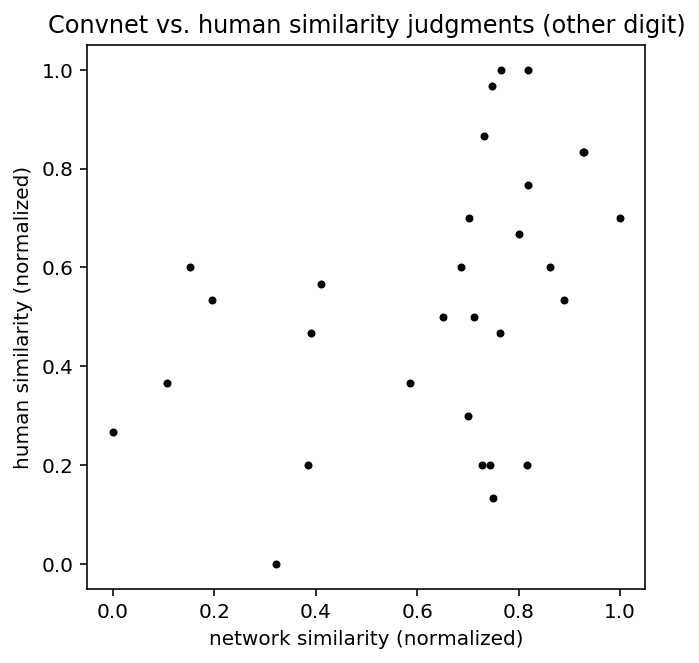

Net2 correlation between net and human similarity ratings for digit 4: r = 0.326


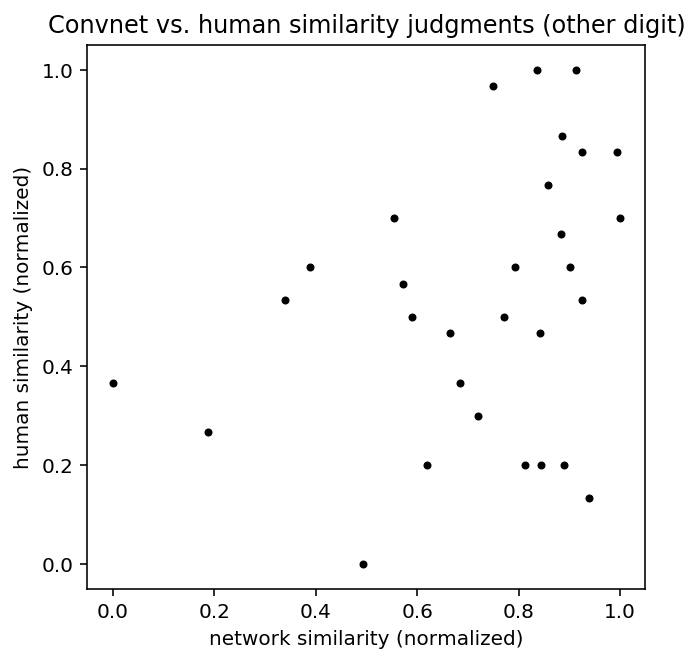

Net3 correlation between net and human similarity ratings for digit 4: r = 0.386


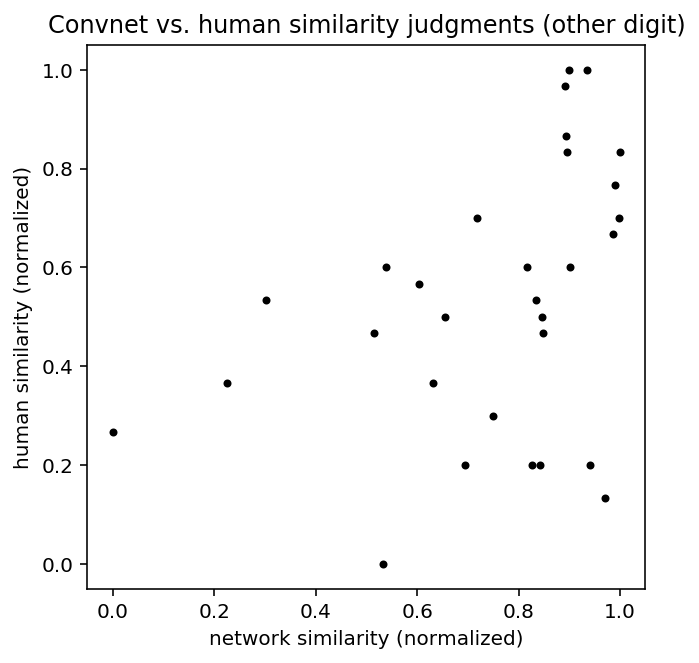

Net4 correlation between net and human similarity ratings for digit 4: r = 0.458


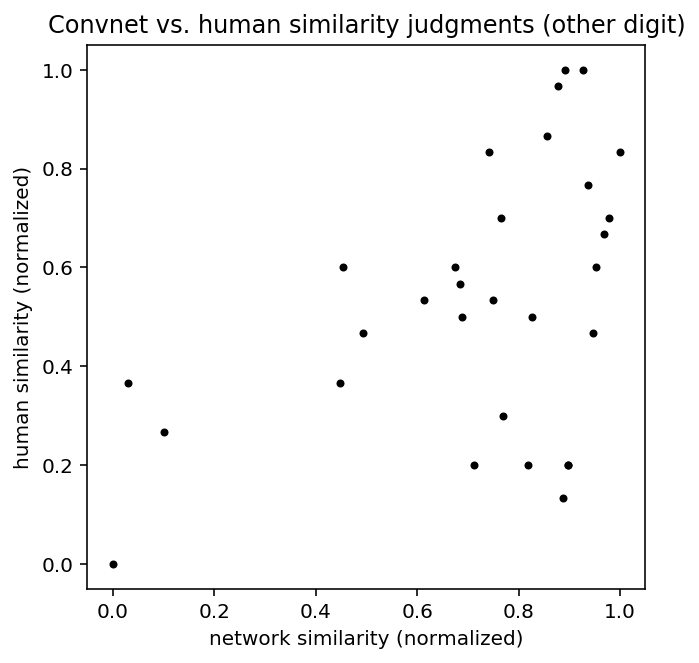

In [12]:
for n, m in zip(['Net1', 'Net2', 'Net3', 'Net4'], [Net1, Net2, Net3, Net4]):

    fc = helper.get_similarity_scores(im4_1, im4_2, m, layer='fc')
    fc = helper.normalize(fc)
    ro = np.corrcoef(fc, avg4norm)[0][1]
    
    print("{0:s} correlation between net and human similarity ratings for digit 4: r = {1:4.3f}".format(n, ro)),
    
    # Scatter plot
    plt.figure(1,figsize=(5,5))
    plt.plot(fc,avg4norm,'k.')
    plt.xlabel('network similarity (normalized)')
    plt.ylabel('human similarity (normalized)')
    plt.title('Convnet vs. human similarity judgments (other digit)')
    plt.show()

    # pairs with similarity ratings
    # plt.figure(2,figsize=(4,40))
    # plot_image_pairs(images1_digit_other,images2_digit_other,v_sim_net_norm,v_sim_human_norm)
    # plt.show()

Net1 correlation between net and human similarity ratings for digit 4: r = 0.629


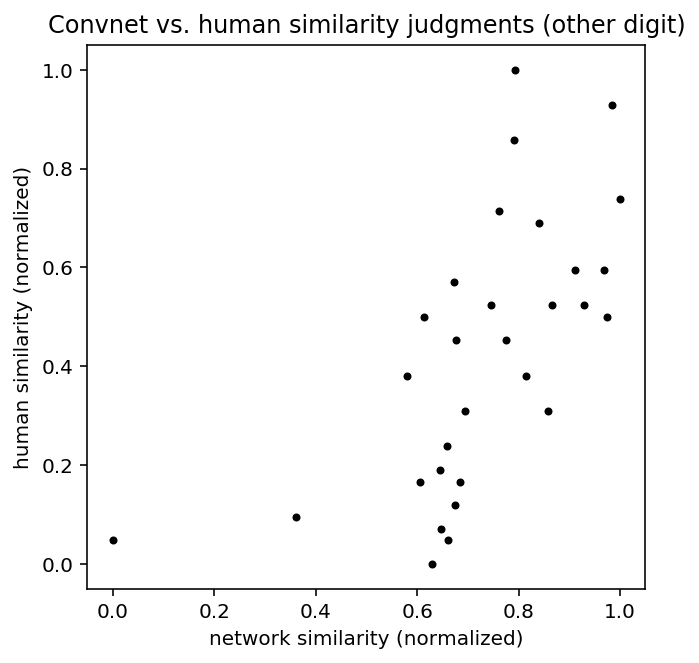

Net2 correlation between net and human similarity ratings for digit 4: r = 0.661


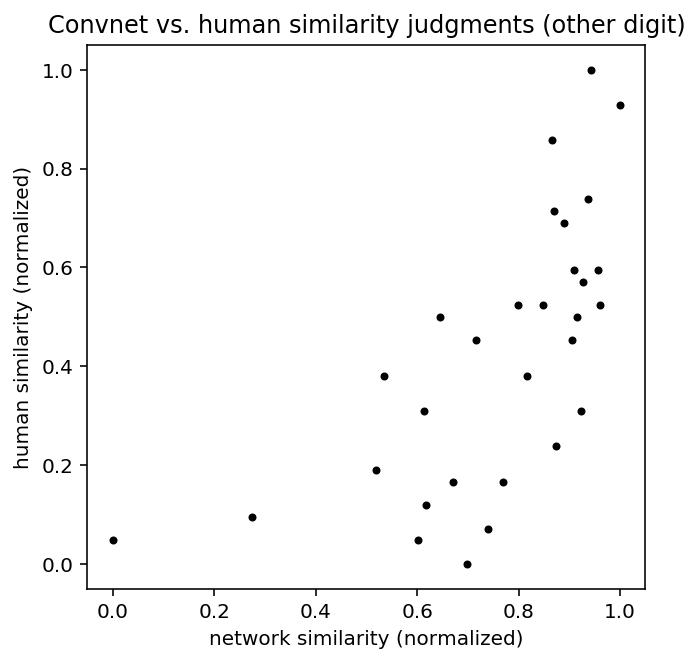

Net3 correlation between net and human similarity ratings for digit 4: r = 0.618


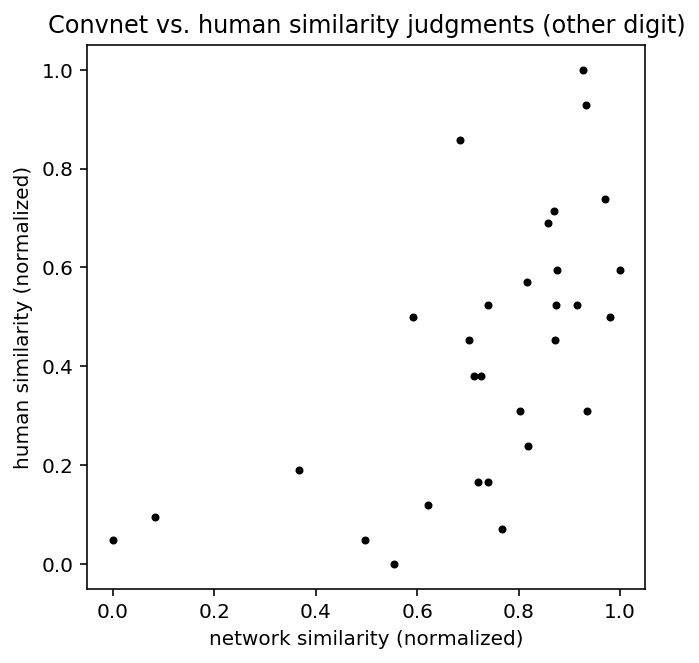

Net4 correlation between net and human similarity ratings for digit 4: r = 0.685


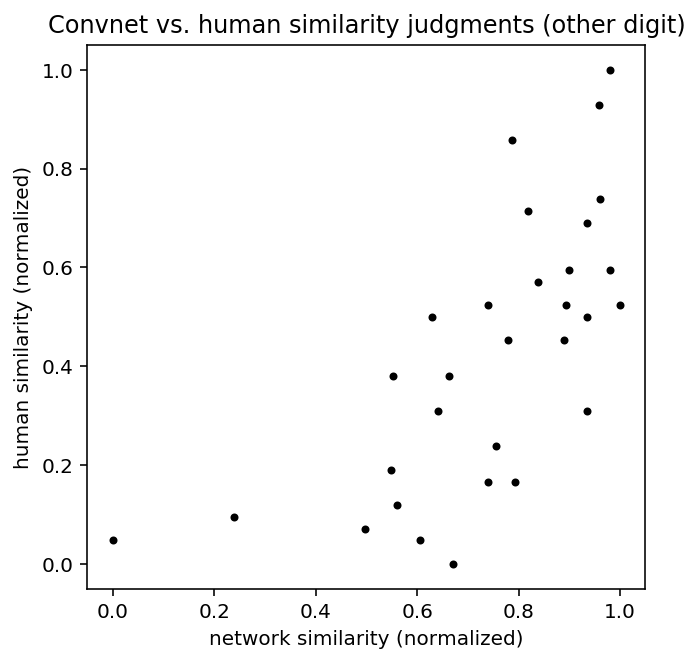

In [13]:
for n, m in zip(['Net1', 'Net2', 'Net3', 'Net4'], [Net1, Net2, Net3, Net4]):

    fc = helper.get_similarity_scores(im7_1, im7_2, m, layer='fc')
    fc = helper.normalize(fc)
    ro = np.corrcoef(fc, avg7norm)[0][1]
    
    print("{0:s} correlation between net and human similarity ratings for digit 4: r = {1:4.3f}".format(n, ro)),
    
    # Scatter plot
    plt.figure(1,figsize=(5,5))
    plt.plot(fc,avg7norm,'k.')
    plt.xlabel('network similarity (normalized)')
    plt.ylabel('human similarity (normalized)')
    plt.title('Convnet vs. human similarity judgments (other digit)')
    plt.show()

Net1 correlation between net and human similarity ratings for digit 4: r = 0.582


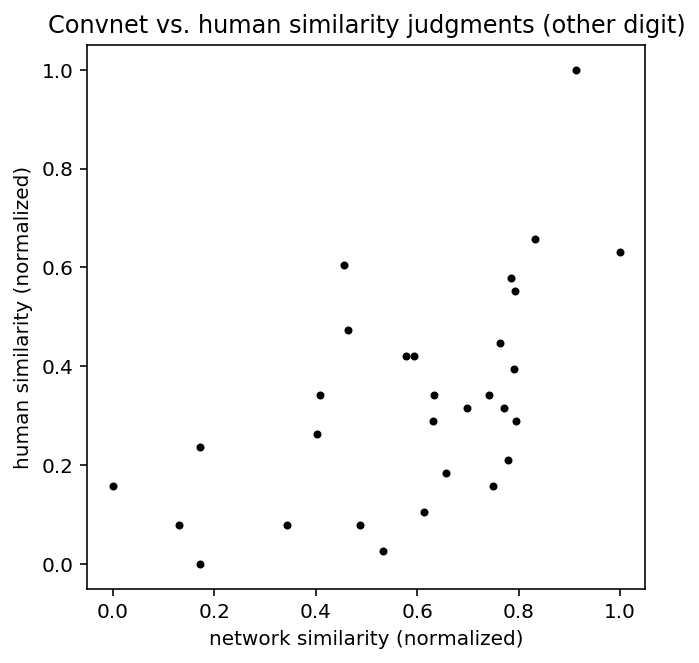

Net2 correlation between net and human similarity ratings for digit 4: r = 0.506


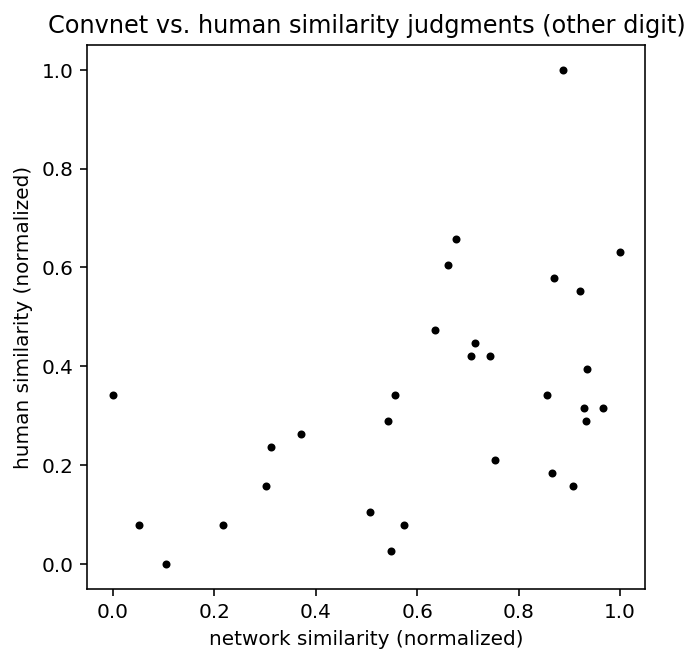

Net3 correlation between net and human similarity ratings for digit 4: r = 0.535


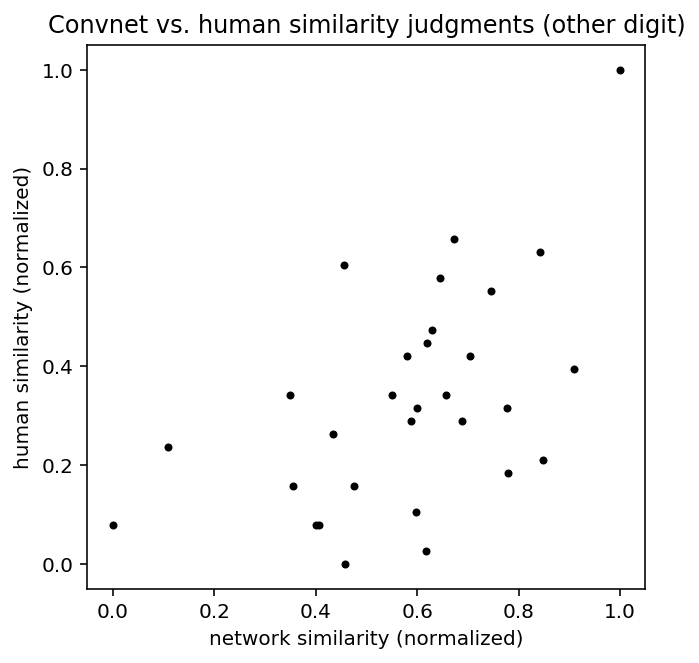

Net4 correlation between net and human similarity ratings for digit 4: r = 0.477


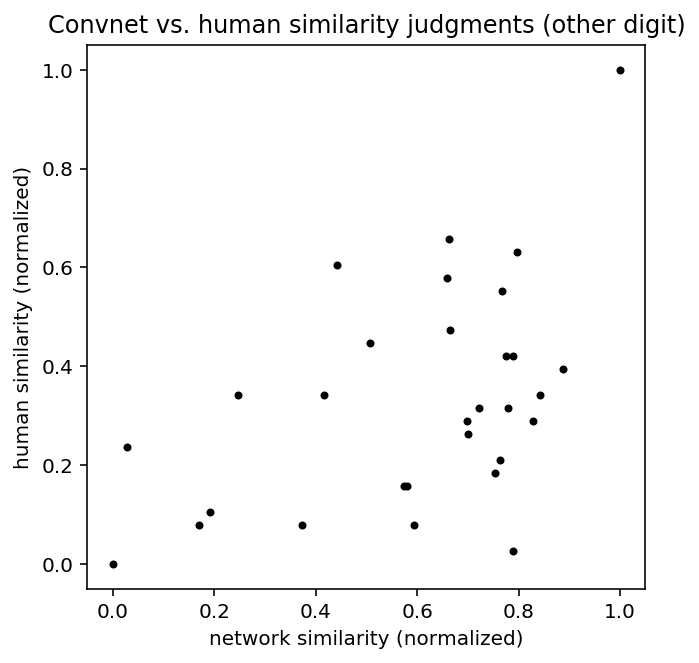

In [14]:
for n, m in zip(['Net1', 'Net2', 'Net3', 'Net4'], [Net1, Net2, Net3, Net4]):

    fc = helper.get_similarity_scores(im8_1, im8_2, m, layer='fc')
    fc = helper.normalize(fc)
    ro = np.corrcoef(fc, avg8norm)[0][1]
    
    print("{0:s} correlation between net and human similarity ratings for digit 4: r = {1:4.3f}".format(n, ro)),
    
    # Scatter plot
    plt.figure(1,figsize=(5,5))
    plt.plot(fc,avg8norm,'k.')
    plt.xlabel('network similarity (normalized)')
    plt.ylabel('human similarity (normalized)')
    plt.title('Convnet vs. human similarity judgments (other digit)')
    plt.show()

Net 1, conv1 correlation between net and human similarity ratings for digit 4: r = 0.510


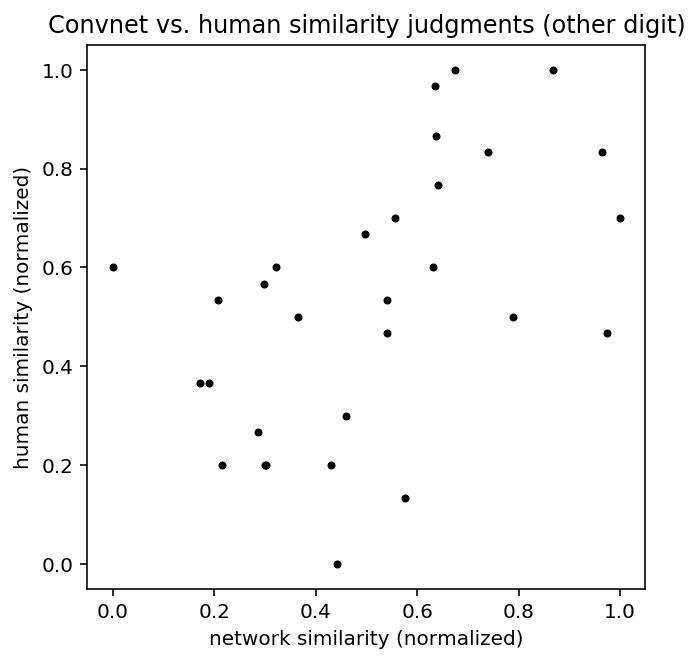

Net 1, fc correlation between net and human similarity ratings for digit 4: r = 0.408


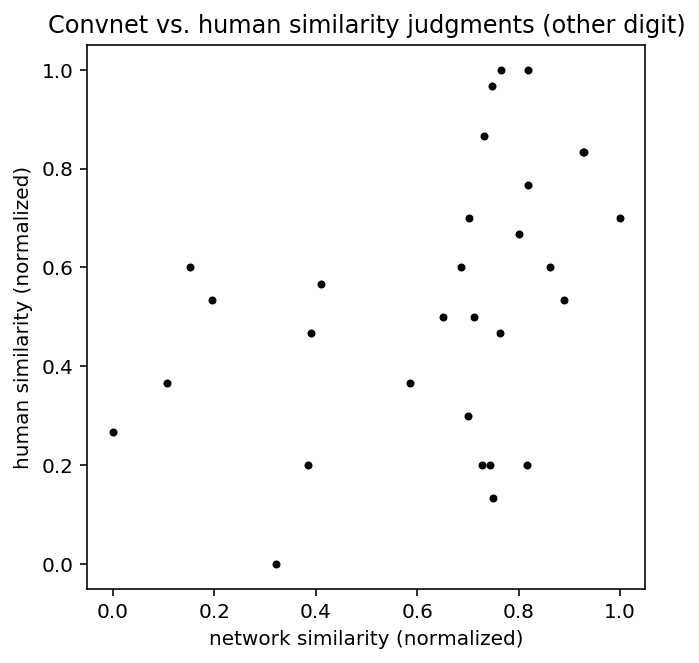

Net 1, conv1 correlation between net and human similarity ratings for digit 7: r = 0.442


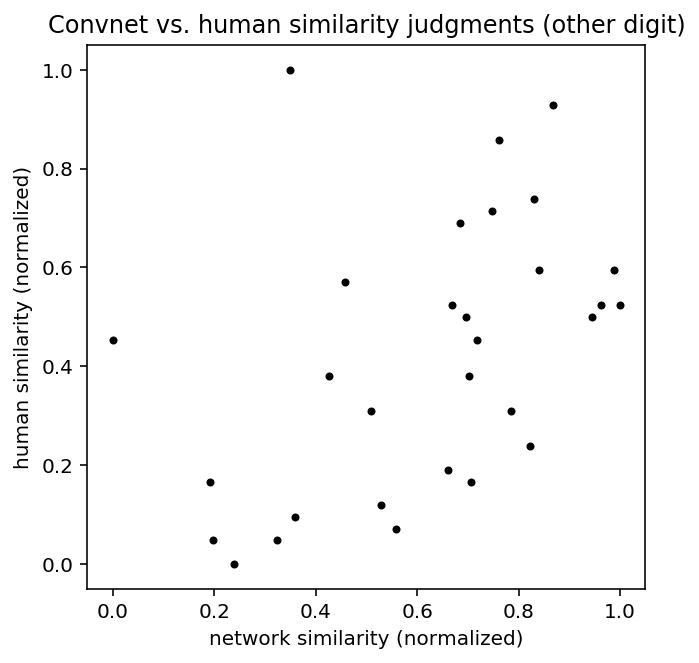

Net 1, fc correlation between net and human similarity ratings for digit 7: r = 0.629


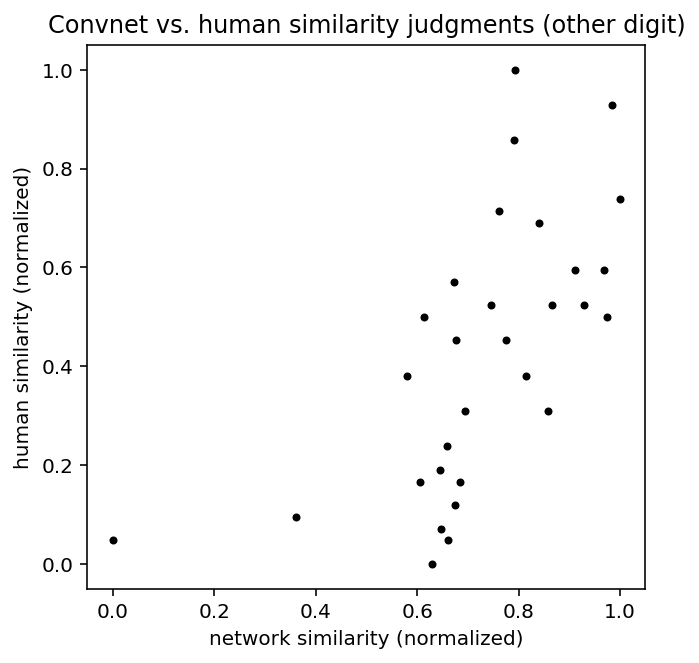

Net 1, conv1 correlation between net and human similarity ratings for digit 8: r = 0.521


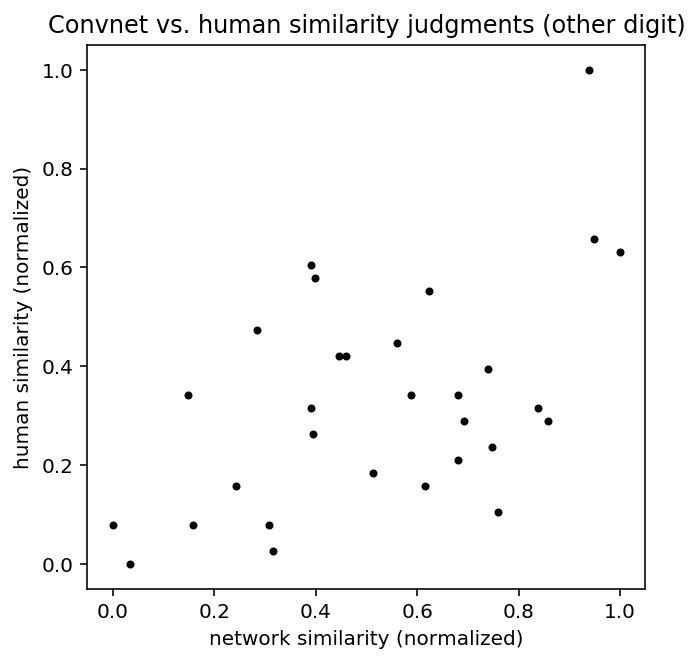

Net 1, fc correlation between net and human similarity ratings for digit 8: r = 0.582


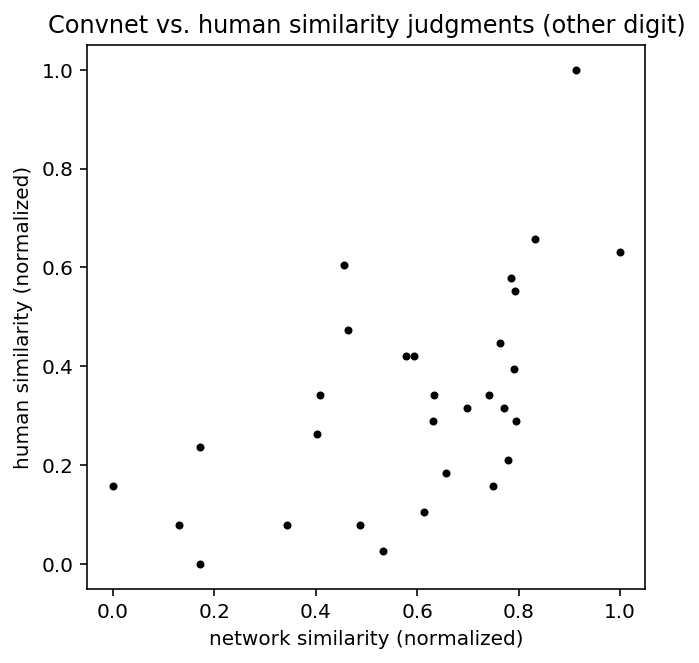

In [15]:
for digit, ims in zip([4,7,8], [(im4_1, im4_2), (im7_1, im7_2), (im8_1, im8_2)]):
    for l in ('conv1', 'fc'):
        im1, im2 = ims
        if digit == 4:
            avg = avg4norm
        elif digit == 7:
            avg = avg7norm
        else:
            avg = avg8norm

        net_sim = helper.get_similarity_scores(im1, im2, Net1, layer=l)
        net_sim = helper.normalize(net_sim)
        ro = np.corrcoef(net_sim, avg)[0][1]

        print("Net 1, {0:s} correlation between net and human similarity ratings for digit {1:d}: r = {2:4.3f}".format(l, digit, ro)),

        # Scatter plot
        plt.figure(1,figsize=(5,5))
        plt.plot(net_sim, avg,'k.')
        plt.xlabel('network similarity (normalized)')
        plt.ylabel('human similarity (normalized)')
        plt.title('Convnet vs. human similarity judgments (other digit)')
        plt.show()


Net 1, conv1 correlation between net and human similarity ratings for digit 4: r = 0.464


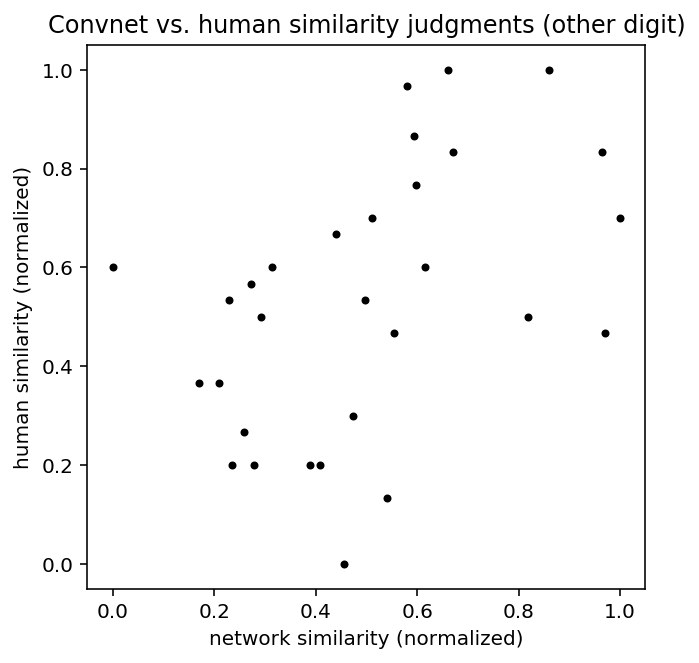

Net 1, conv2 correlation between net and human similarity ratings for digit 4: r = 0.513


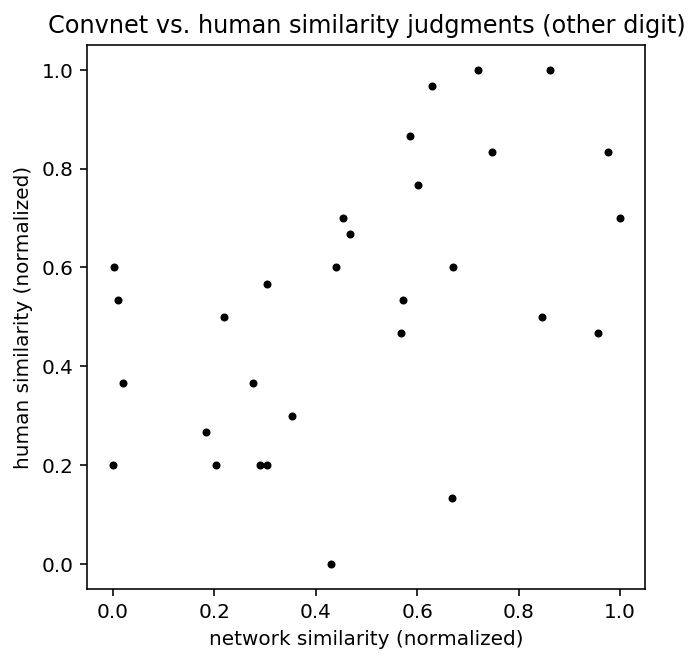

Net 1, fc correlation between net and human similarity ratings for digit 4: r = 0.326


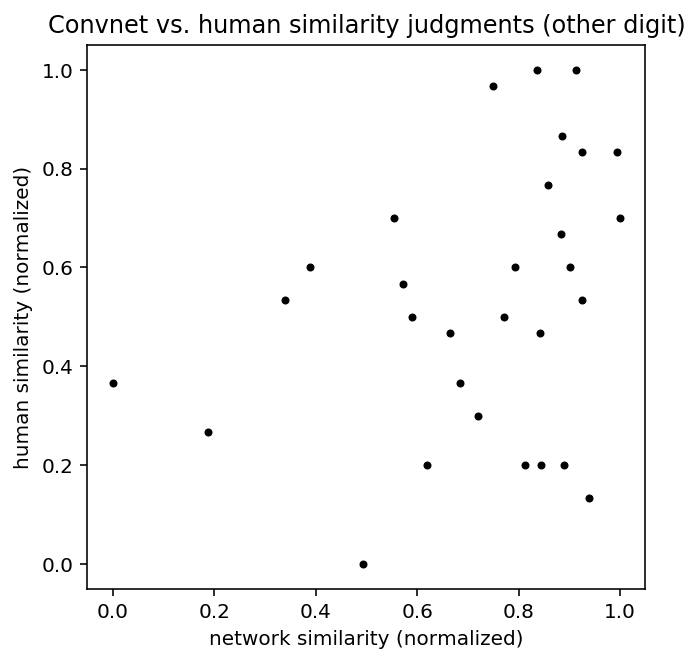

Net 1, conv1 correlation between net and human similarity ratings for digit 7: r = 0.426


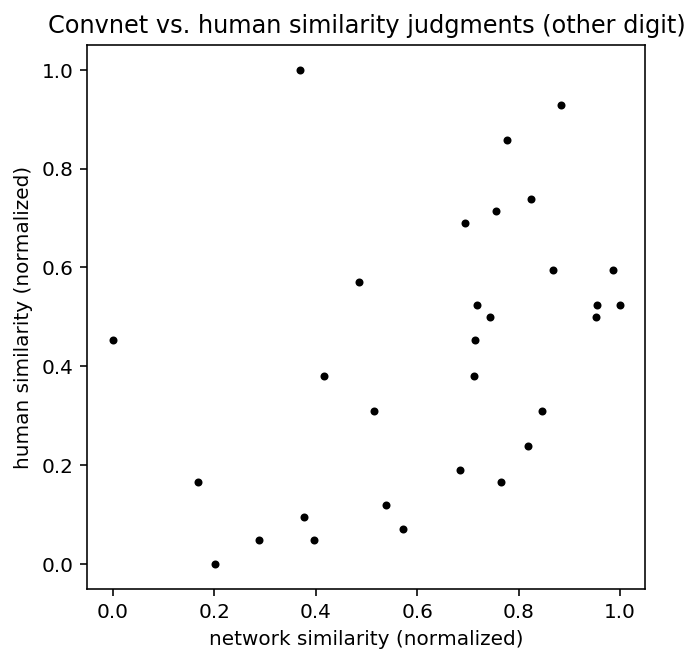

Net 1, conv2 correlation between net and human similarity ratings for digit 7: r = 0.433


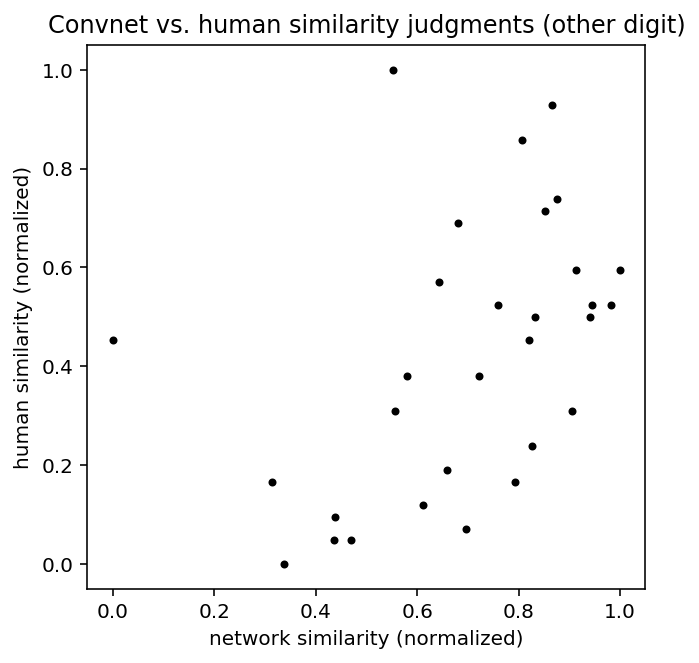

Net 1, fc correlation between net and human similarity ratings for digit 7: r = 0.661


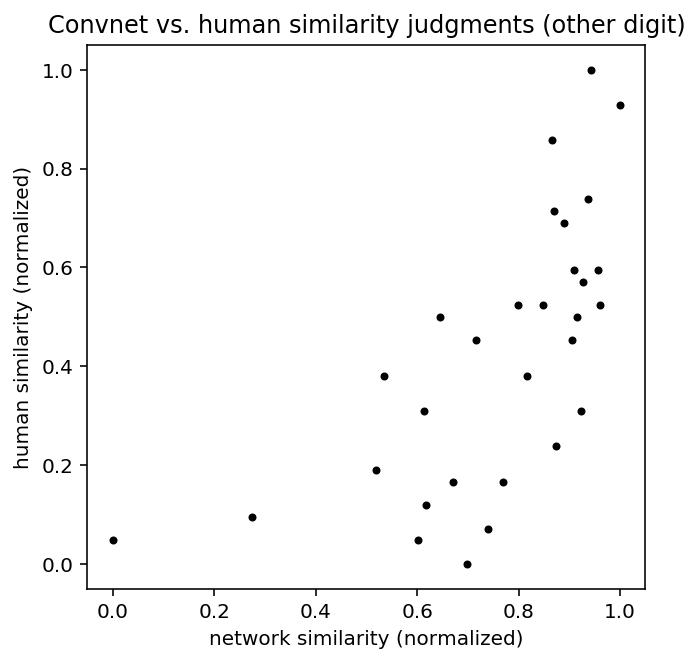

Net 1, conv1 correlation between net and human similarity ratings for digit 8: r = 0.506


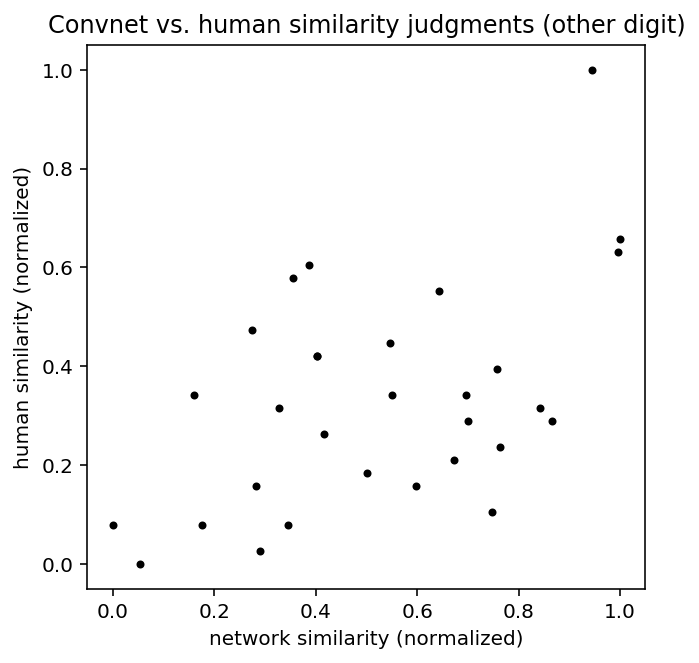

Net 1, conv2 correlation between net and human similarity ratings for digit 8: r = 0.512


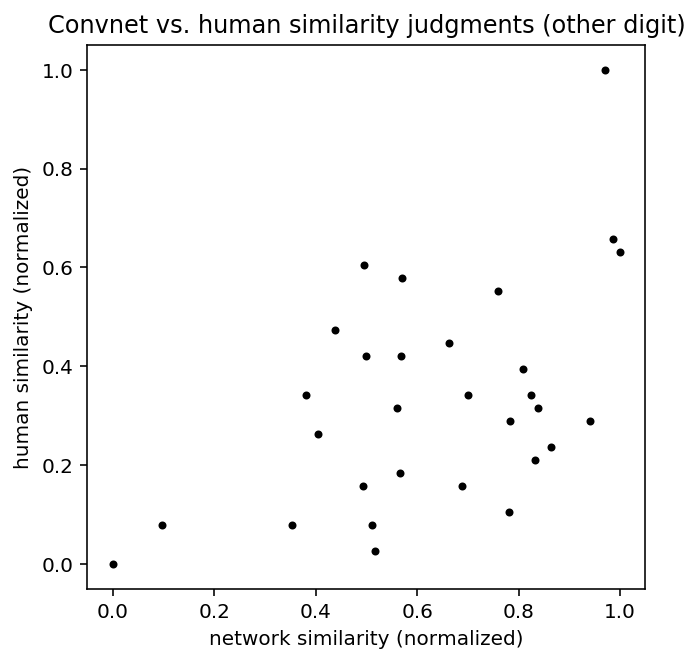

Net 1, fc correlation between net and human similarity ratings for digit 8: r = 0.506


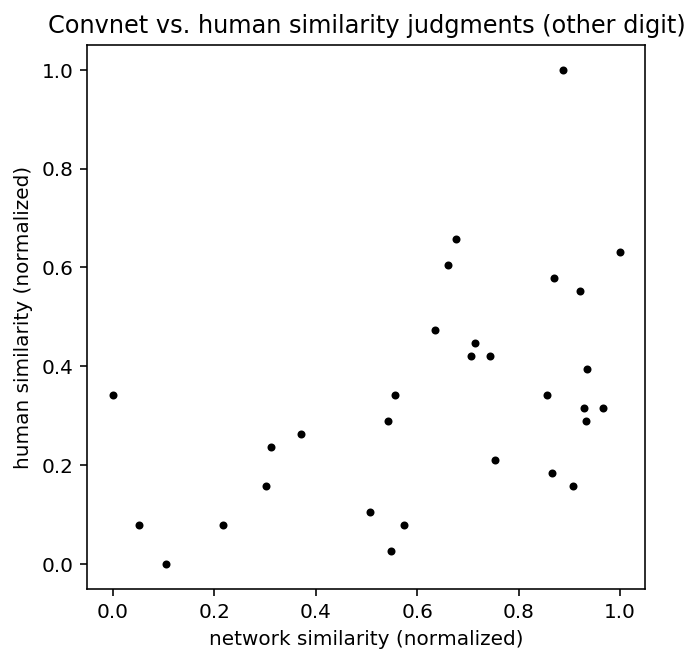

In [16]:
for digit, ims in zip([4,7,8], [(im4_1, im4_2), (im7_1, im7_2), (im8_1, im8_2)]):
    for l in ('conv1', 'conv2', 'fc'):
        im1, im2 = ims
        if digit == 4:
            avg = avg4norm
        elif digit == 7:
            avg = avg7norm
        else:
            avg = avg8norm

        net_sim = helper.get_similarity_scores(im1, im2, Net2, layer=l)
        net_sim = helper.normalize(net_sim)
        ro = np.corrcoef(net_sim, avg)[0][1]

        print("Net 1, {0:s} correlation between net and human similarity ratings for digit {1:d}: r = {2:4.3f}".format(l, digit, ro)),

        # Scatter plot
        plt.figure(1,figsize=(5,5))
        plt.plot(net_sim, avg,'k.')
        plt.xlabel('network similarity (normalized)')
        plt.ylabel('human similarity (normalized)')
        plt.title('Convnet vs. human similarity judgments (other digit)')
        plt.show()

Net 1, conv1 correlation between net and human similarity ratings for digit 4: r = 0.472


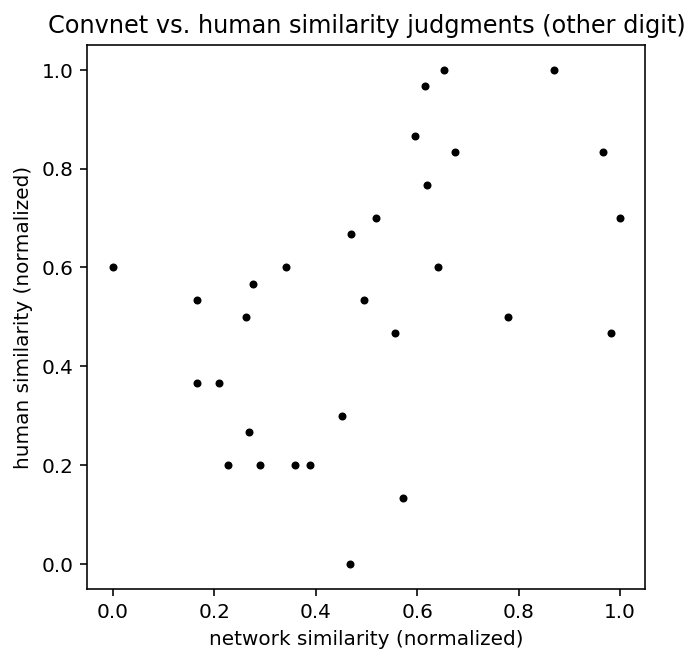

Net 1, conv2 correlation between net and human similarity ratings for digit 4: r = 0.489


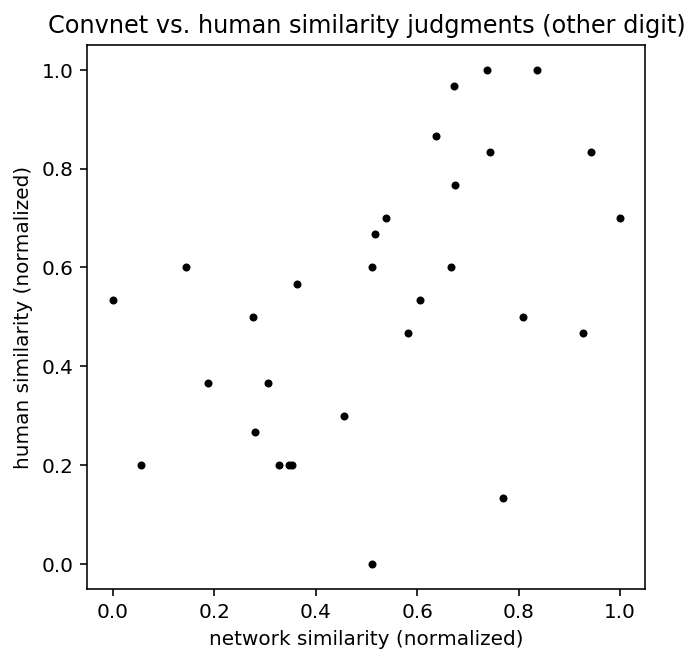

Net 1, conv3 correlation between net and human similarity ratings for digit 4: r = 0.566


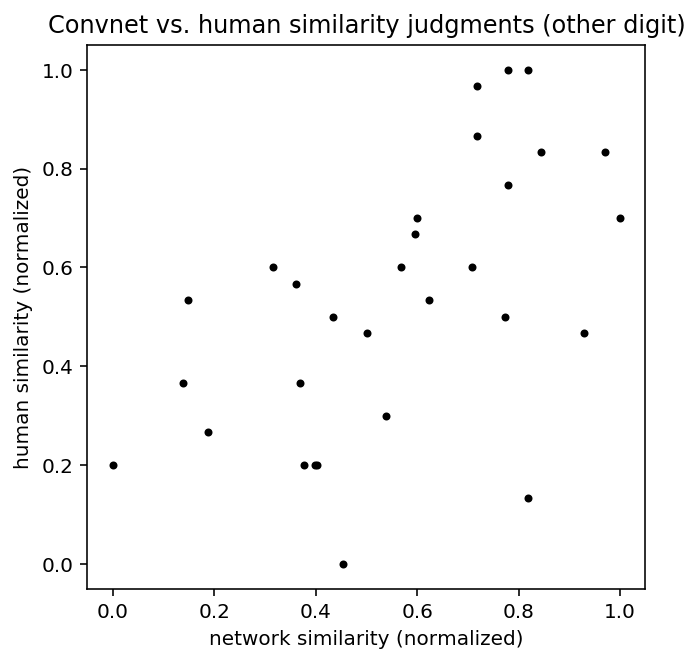

Net 1, fc correlation between net and human similarity ratings for digit 4: r = 0.386


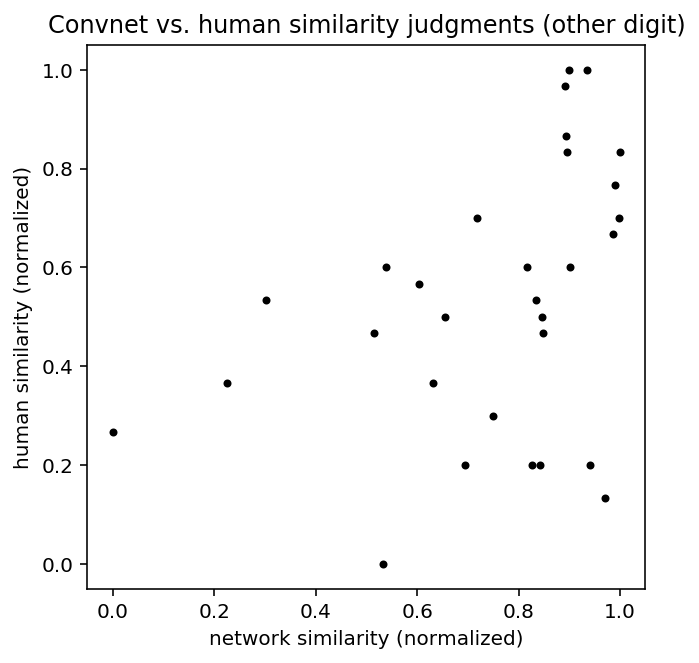

Net 1, conv1 correlation between net and human similarity ratings for digit 7: r = 0.417


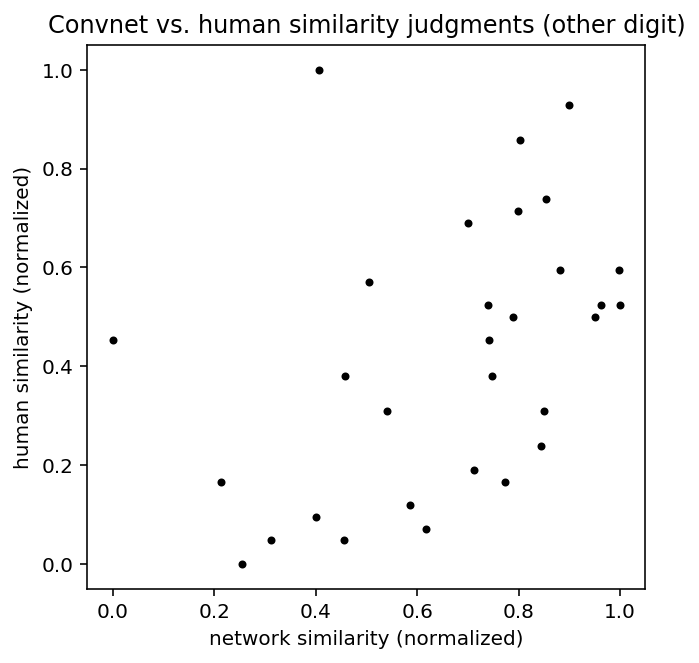

Net 1, conv2 correlation between net and human similarity ratings for digit 7: r = 0.397


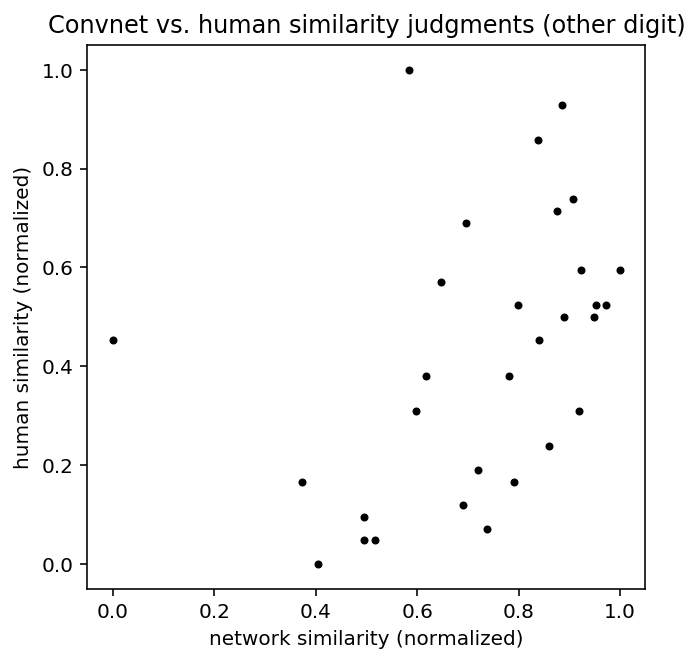

Net 1, conv3 correlation between net and human similarity ratings for digit 7: r = 0.539


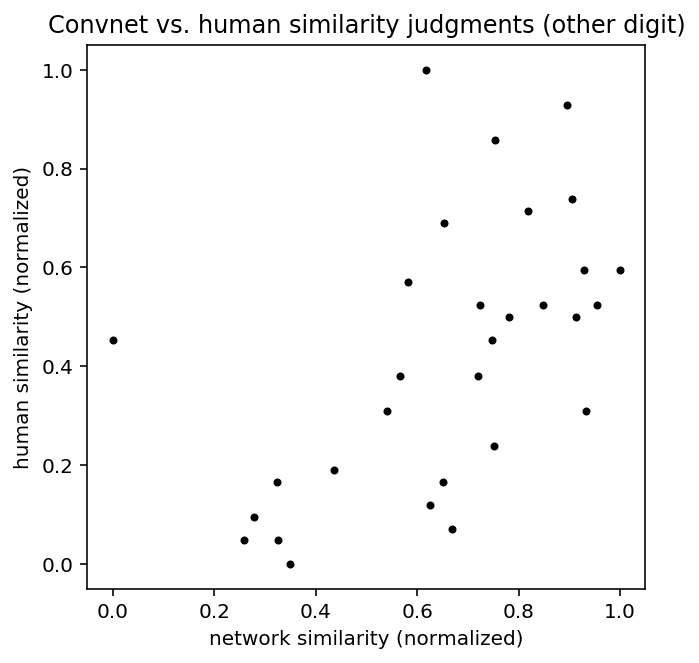

Net 1, fc correlation between net and human similarity ratings for digit 7: r = 0.618


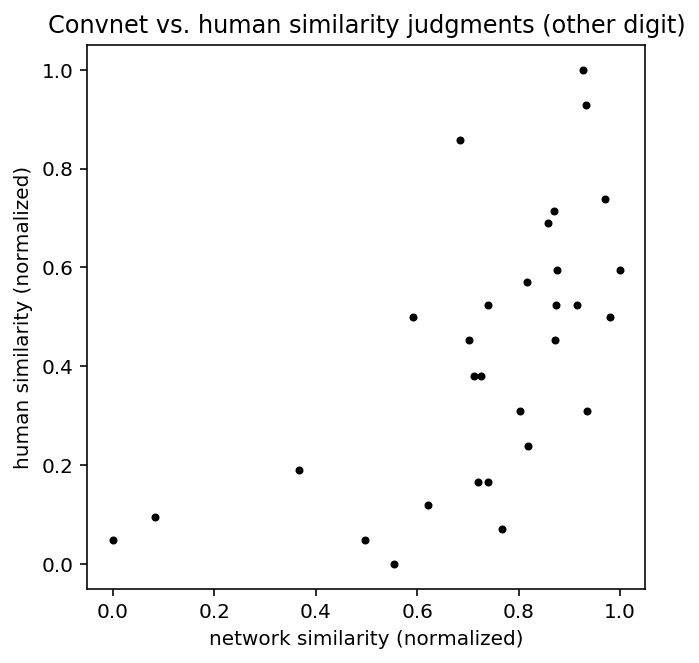

Net 1, conv1 correlation between net and human similarity ratings for digit 8: r = 0.503


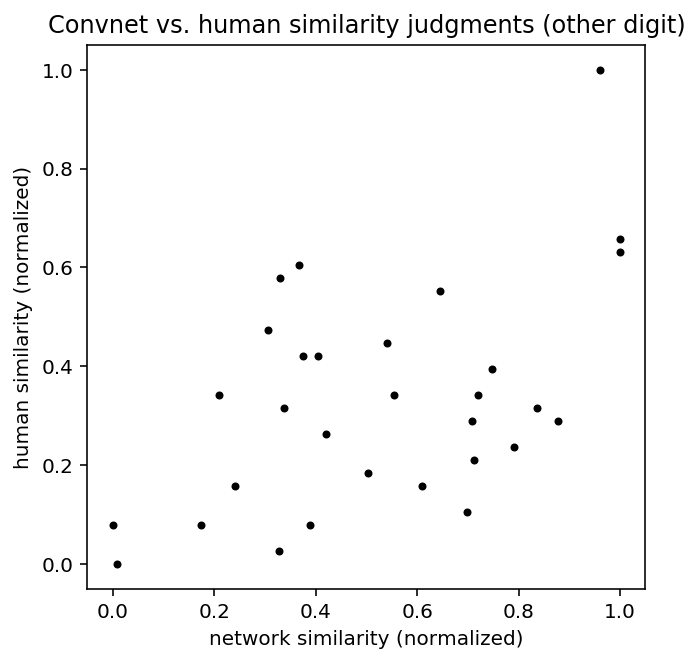

Net 1, conv2 correlation between net and human similarity ratings for digit 8: r = 0.486


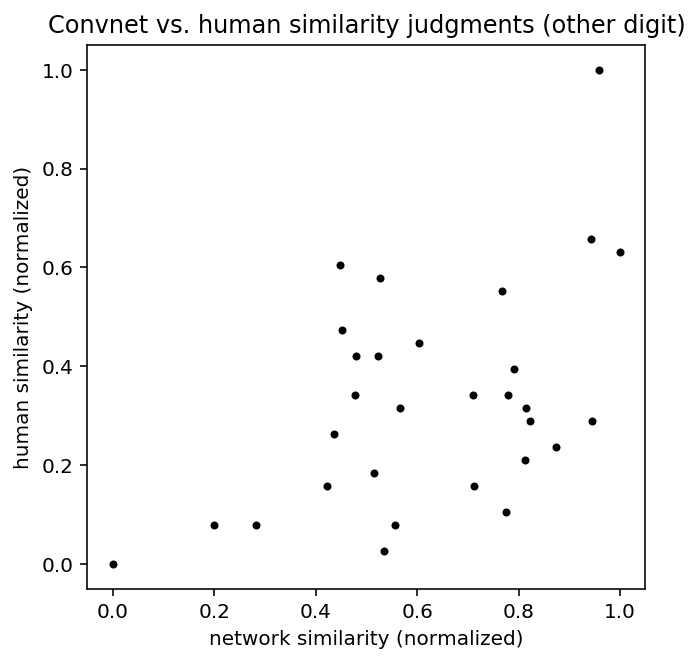

Net 1, conv3 correlation between net and human similarity ratings for digit 8: r = 0.545


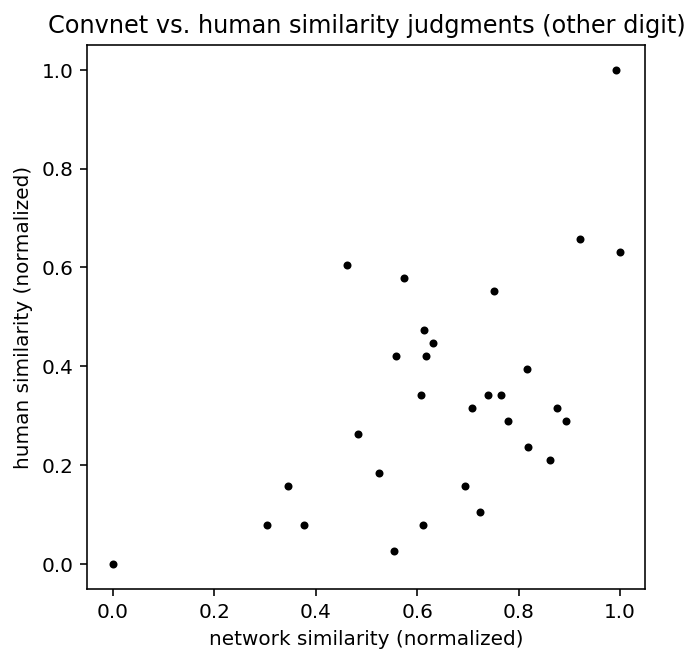

Net 1, fc correlation between net and human similarity ratings for digit 8: r = 0.535


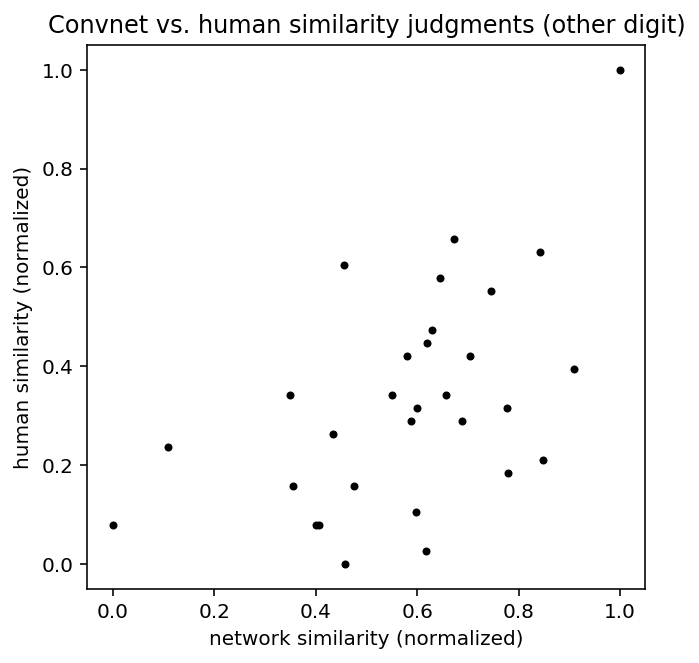

In [17]:
for digit, ims in zip([4,7,8], [(im4_1, im4_2), (im7_1, im7_2), (im8_1, im8_2)]):
    for l in ('conv1', 'conv2', 'conv3', 'fc'):
        im1, im2 = ims
        if digit == 4:
            avg = avg4norm
        elif digit == 7:
            avg = avg7norm
        else:
            avg = avg8norm

        net_sim = helper.get_similarity_scores(im1, im2, Net3, layer=l)
        net_sim = helper.normalize(net_sim)
        ro = np.corrcoef(net_sim, avg)[0][1]

        print("Net 1, {0:s} correlation between net and human similarity ratings for digit {1:d}: r = {2:4.3f}".format(l, digit, ro)),

        # Scatter plot
        plt.figure(1,figsize=(5,5))
        plt.plot(net_sim, avg,'k.')
        plt.xlabel('network similarity (normalized)')
        plt.ylabel('human similarity (normalized)')
        plt.title('Convnet vs. human similarity judgments (other digit)')
        plt.show()
        

Net 1, conv1 correlation between net and human similarity ratings for digit 4: r = 0.481


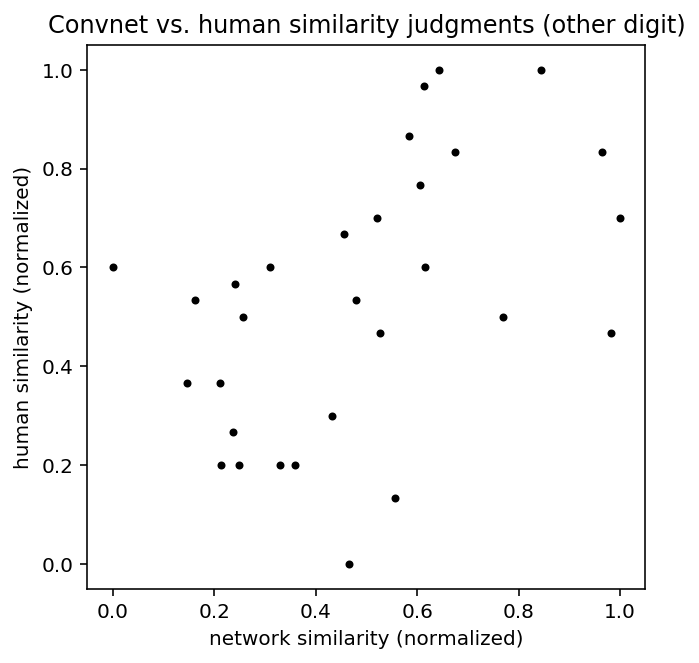

Net 1, conv2 correlation between net and human similarity ratings for digit 4: r = 0.502


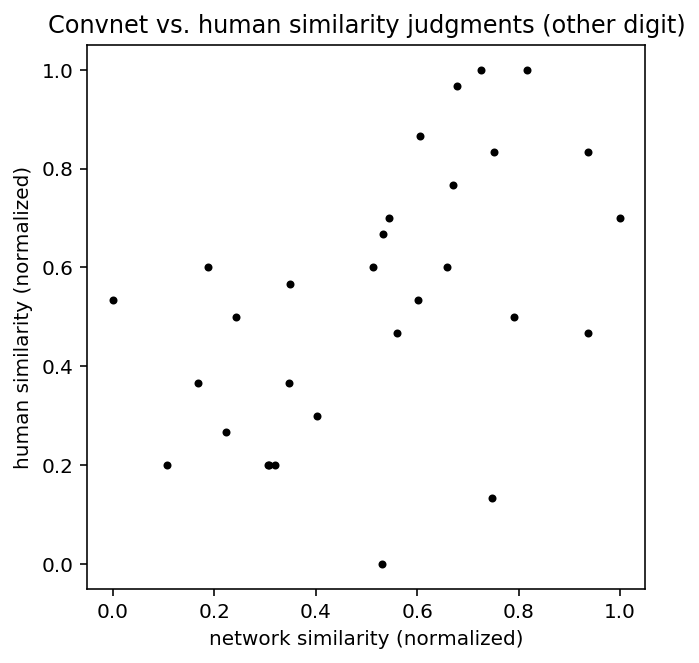

Net 1, conv3 correlation between net and human similarity ratings for digit 4: r = 0.540


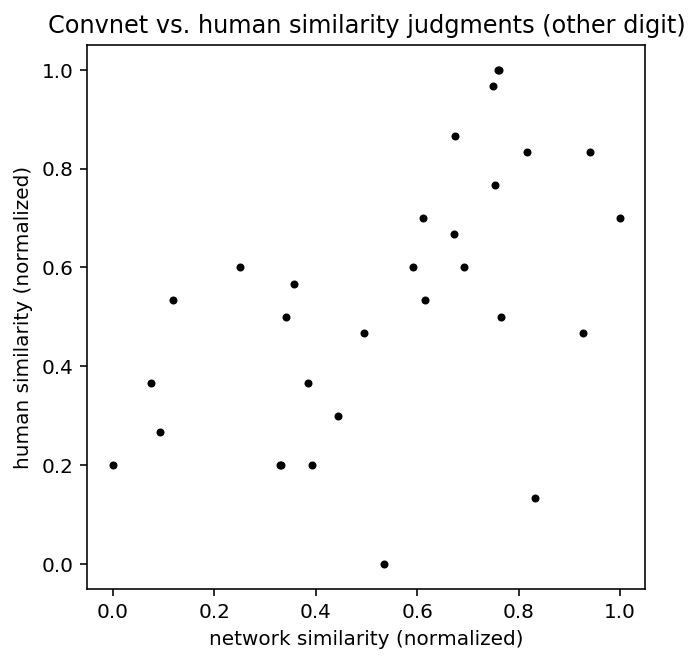

Net 1, conv4 correlation between net and human similarity ratings for digit 4: r = 0.503


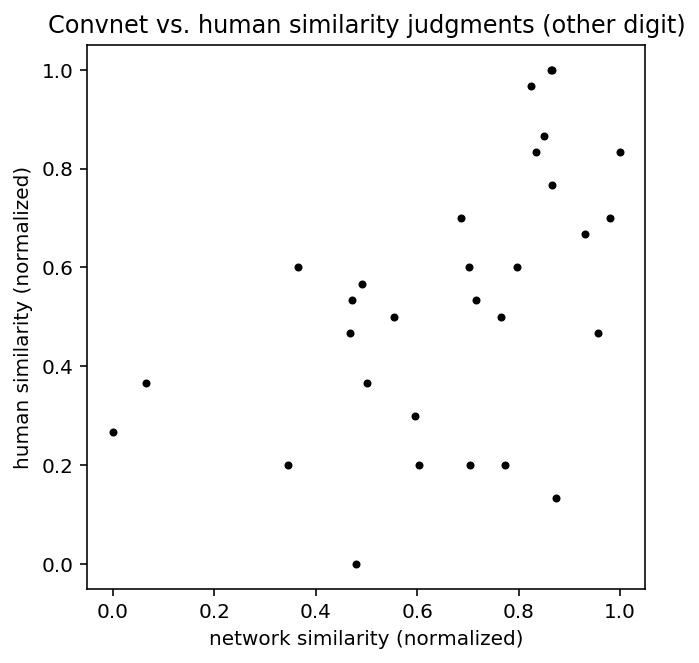

Net 1, fc correlation between net and human similarity ratings for digit 4: r = 0.458


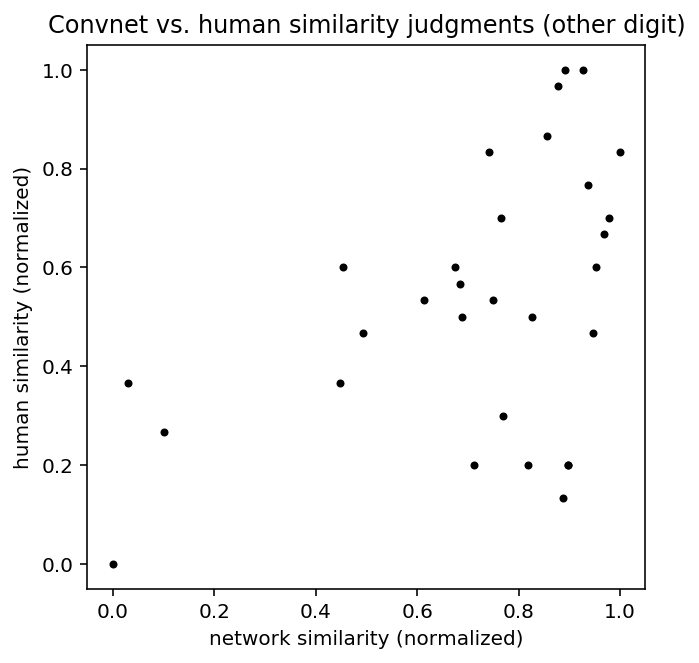

Net 1, conv1 correlation between net and human similarity ratings for digit 7: r = 0.415


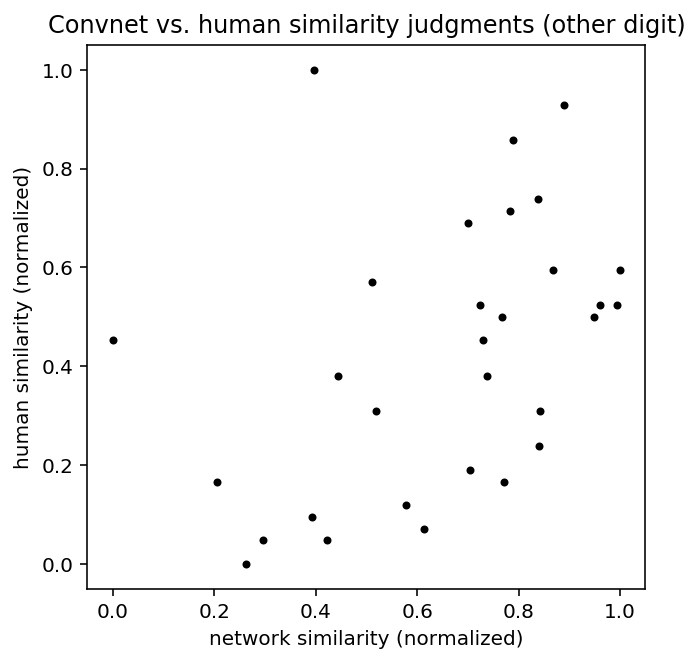

Net 1, conv2 correlation between net and human similarity ratings for digit 7: r = 0.389


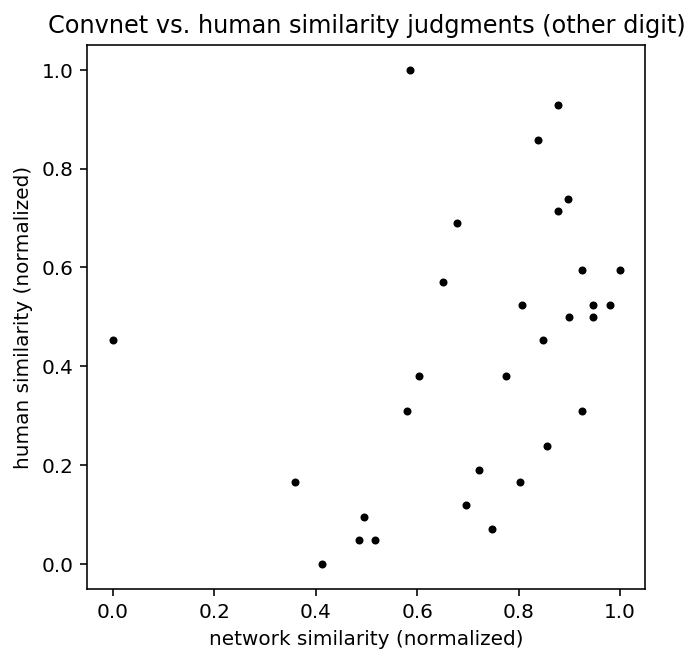

Net 1, conv3 correlation between net and human similarity ratings for digit 7: r = 0.536


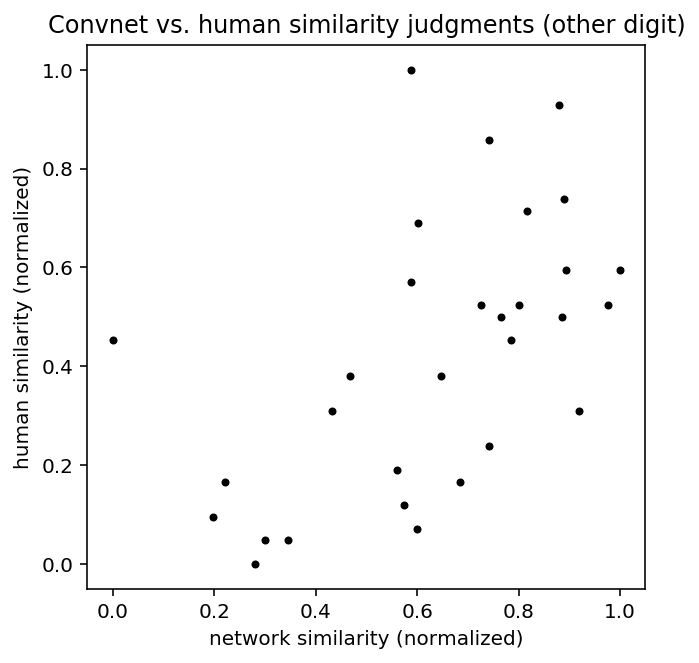

Net 1, conv4 correlation between net and human similarity ratings for digit 7: r = 0.696


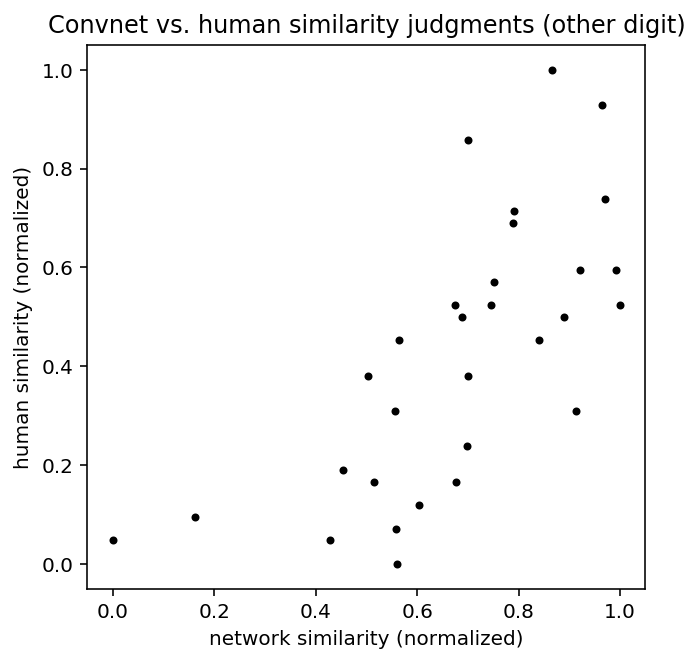

Net 1, fc correlation between net and human similarity ratings for digit 7: r = 0.685


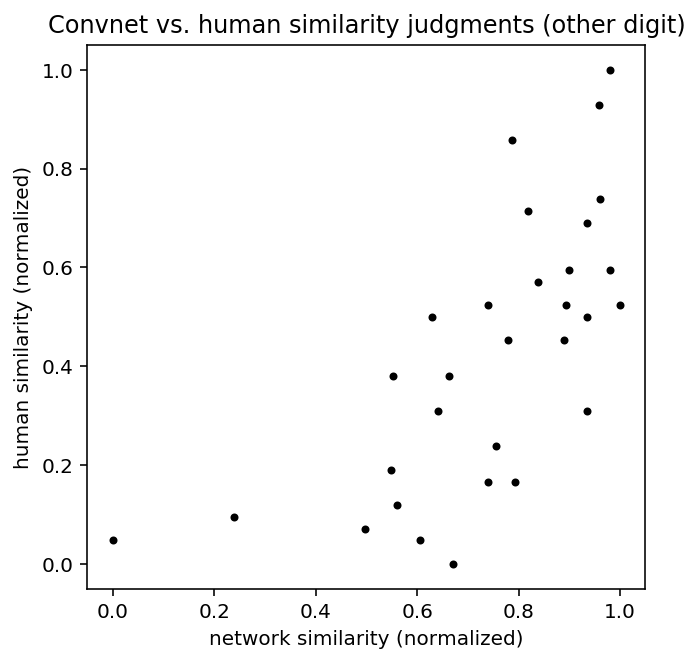

Net 1, conv1 correlation between net and human similarity ratings for digit 8: r = 0.498


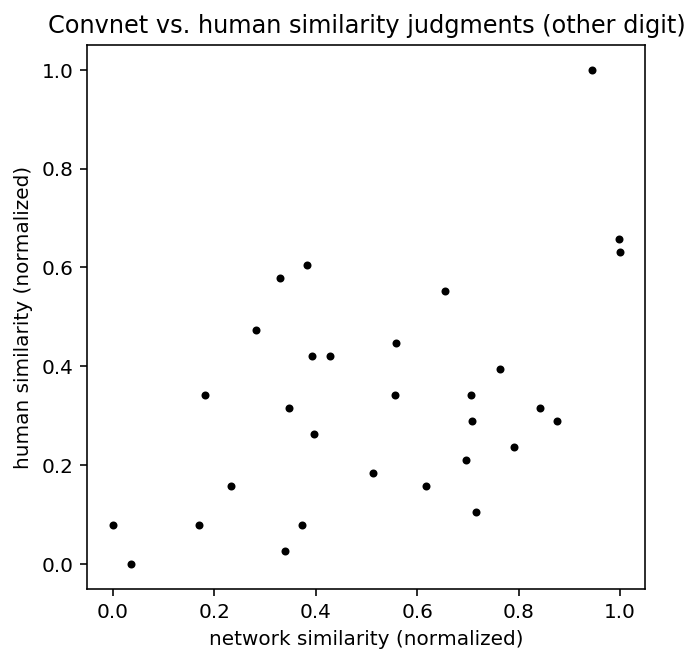

Net 1, conv2 correlation between net and human similarity ratings for digit 8: r = 0.473


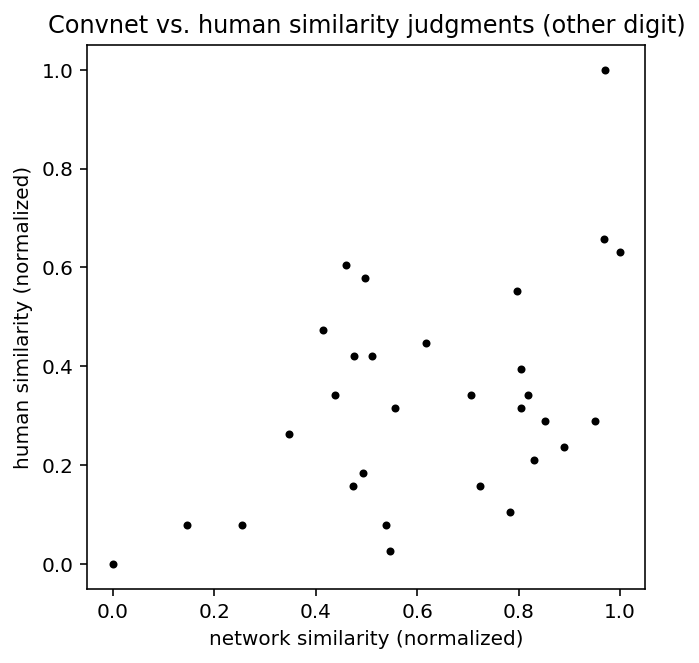

Net 1, conv3 correlation between net and human similarity ratings for digit 8: r = 0.520


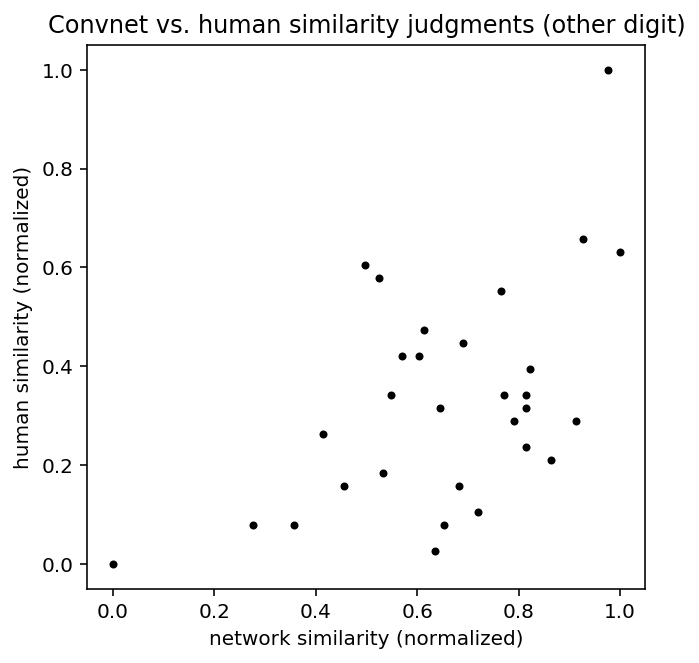

Net 1, conv4 correlation between net and human similarity ratings for digit 8: r = 0.562


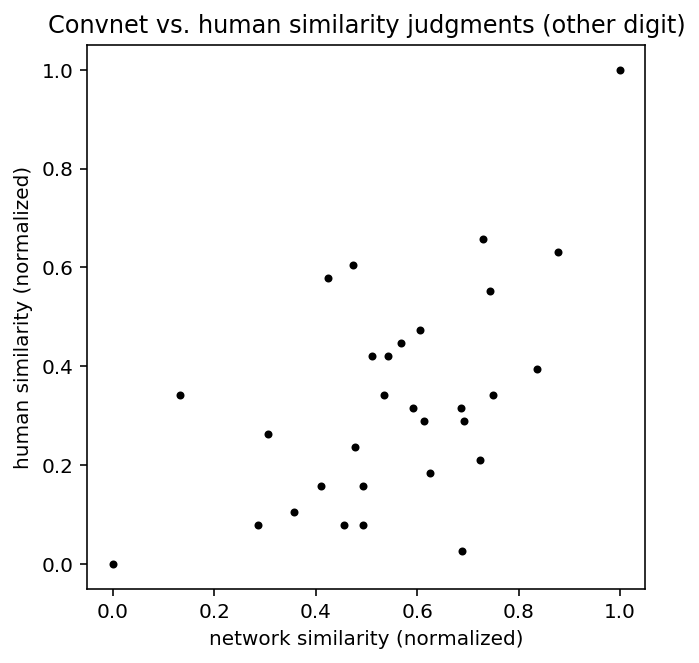

Net 1, fc correlation between net and human similarity ratings for digit 8: r = 0.477


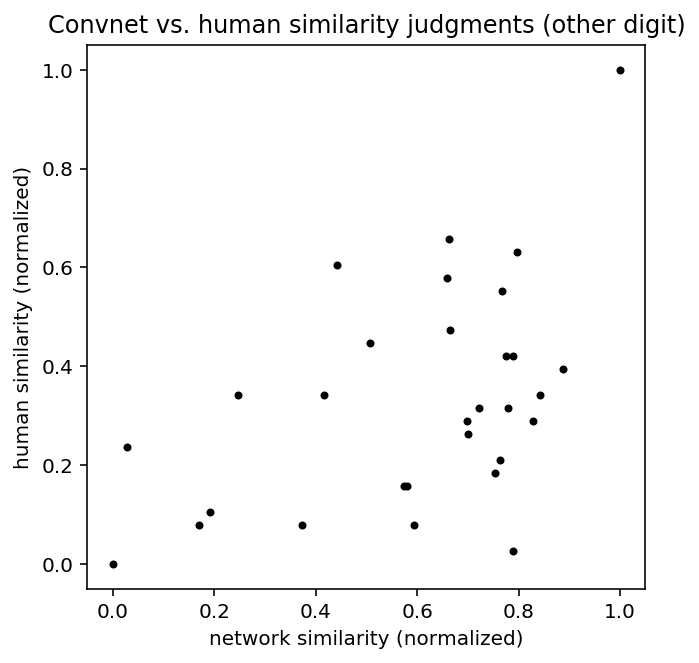

In [18]:
for digit, ims in zip([4,7,8], [(im4_1, im4_2), (im7_1, im7_2), (im8_1, im8_2)]):
    for l in ('conv1', 'conv2', 'conv3', 'conv4', 'fc'):
        im1, im2 = ims
        if digit == 4:
            avg = avg4norm
        elif digit == 7:
            avg = avg7norm
        else:
            avg = avg8norm

        net_sim = helper.get_similarity_scores(im1, im2, Net4, layer=l)
        net_sim = helper.normalize(net_sim)
        ro = np.corrcoef(net_sim, avg)[0][1]

        print("Net 1, {0:s} correlation between net and human similarity ratings for digit {1:d}: r = {2:4.3f}".format(l, digit, ro)),

        # Scatter plot
        plt.figure(1,figsize=(5,5))
        plt.plot(net_sim, avg,'k.')
        plt.xlabel('network similarity (normalized)')
        plt.ylabel('human similarity (normalized)')
        plt.title('Convnet vs. human similarity judgments (other digit)')
        plt.show()
        

In [19]:
m_layers = [('conv1', 'fc'),('conv1', 'conv2', 'fc'),('conv1', 'conv2', 'conv3', 'fc'),('conv1', 'conv2', 'conv3', 'conv4', 'fc')]

sim4 = np.zeros((30, 2+3+4+5))
sim7 = np.zeros((30, 2+3+4+5))
sim8 = np.zeros((30, 2+3+4+5))
ro4 = np.zeros((1, 2+3+4+5))
ro7 = np.zeros((1, 2+3+4+5))
ro8 = np.zeros((1, 2+3+4+5))
cols = []
ro_list = [ro4, ro7, ro8]
sim_list = [sim4, sim7, sim8]

for ix, (digit, ims) in enumerate(zip([4,7,8], [(im4_1, im4_2), (im7_1, im7_2), (im8_1, im8_2)])):
    im1, im2 = ims
    if digit == 4:
        avg = avg4norm
    elif digit == 7:
        avg = avg7norm
    else:
        avg = avg8norm
    
    i = 0
    for m, n, layers in zip([Net1, Net2, Net3, Net4], ['Net1', 'Net2', 'Net3', 'Net4'], m_layers):
        for l in layers:
            cols.append('_'.join([n,l]))
            net_sim = helper.normalize(helper.get_similarity_scores(im1, im2, m, layer=l))
            ro = np.corrcoef(net_sim, avg)[0][1]
            
            sim_list[ix][:,i] = net_sim
            ro_list[ix][:,i] = ro
            
            i += 1

cols = ['human']+cols[:14]
df4 = pd.DataFrame(np.hstack((np.array([0]+avg4norm.tolist()).reshape(-1,1), np.vstack((ro4, sim4)))), columns=cols)
df7 = pd.DataFrame(np.hstack((np.array([0]+avg7norm.tolist()).reshape(-1,1), np.vstack((ro7, sim7)))), columns=cols)
df8 = pd.DataFrame(np.hstack((np.array([0]+avg8norm.tolist()).reshape(-1,1), np.vstack((ro8, sim8)))), columns=cols)

In [20]:
df4.to_csv('files_for_comparison/digit_4_sim_table.csv', index=False)
df7.to_csv('files_for_comparison/digit_7_sim_table.csv', index=False)
df8.to_csv('files_for_comparison/digit_8_sim_table.csv', index=False)

In [21]:
df4

,human,Net1_conv1,Net1_fc,Net2_conv1,Net2_conv2,Net2_fc,Net3_conv1,Net3_conv2,Net3_conv3,Net3_fc,Net4_conv1,Net4_conv2,Net4_conv3,Net4_conv4,Net4_fc
0,0.000000,0.509692,0.408058,0.463820,0.513201,0.326484,0.472457,0.489149,0.566141,0.386121,0.480914,0.502101,0.539857,0.503380,0.457725
1,0.533333,0.207787,0.194854,0.228981,0.009340,0.340308,0.166889,0.000000,0.148225,0.302252,0.161912,0.000000,0.118289,0.471432,0.613987
2,1.000000,0.867116,0.819412,0.859661,0.862516,0.914166,0.869913,0.835357,0.778722,0.899094,0.844815,0.816618,0.760949,0.866284,0.927693
3,0.700000,0.557031,0.701836,0.510344,0.452941,0.554363,0.518991,0.537806,0.599322,0.717792,0.520377,0.544591,0.610776,0.686048,0.764740
4,0.833333,0.739570,0.929869,0.670949,0.746873,0.925741,0.675642,0.743671,0.843461,0.895321,0.675446,0.751084,0.817398,0.834706,0.741962
5,0.366667,0.172684,0.106240,0.170911,0.019442,0.000000,0.166833,0.187613,0.138187,0.224467,0.146808,0.168865,0.075918,0.065062,0.031017
6,0.500000,0.365754,0.651550,0.292508,0.218462,0.771137,0.262489,0.276459,0.434021,0.846413,0.257584,0.243776,0.341692,0.553449,0.688873
7,0.566667,0.297931,0.410888,0.271626,0.303252,0.572876,0.276746,0.363181,0.360415,0.602748,0.241725,0.349321,0.357449,0.490400,0.684176
8,0.833333,0.963587,0.927247,0.964879,0.977204,0.994770,0.966825,0.943322,0.970986,1.000000,0.964223,0.936156,0.940285,1.000000,1.000000
9,0.366667,0.190190,0.586444,0.208935,0.275912,0.685270,0.209889,0.306694,0.370015,0.630876,0.211201,0.347732,0.385555,0.500563,0.448841


In [22]:
df7

,human,Net1_conv1,Net1_fc,Net2_conv1,Net2_conv2,Net2_fc,Net3_conv1,Net3_conv2,Net3_conv3,Net3_fc,Net4_conv1,Net4_conv2,Net4_conv3,Net4_conv4,Net4_fc
0,0.000000,0.441741,0.628772,0.426148,0.433467,0.660576,0.416666,0.397457,0.538910,0.617915,0.415429,0.388635,0.535527,0.696246,0.685085
1,0.238095,0.823388,0.658346,0.819439,0.827137,0.873577,0.844602,0.860260,0.750984,0.819508,0.840551,0.855633,0.741053,0.698390,0.754889
2,0.190476,0.660957,0.645888,0.685022,0.659409,0.518714,0.711758,0.719083,0.436671,0.367052,0.705060,0.722871,0.560185,0.453568,0.548431
3,0.166667,0.705899,0.684561,0.764594,0.792853,0.769059,0.772824,0.790188,0.651890,0.720897,0.771269,0.802508,0.684831,0.676266,0.792890
4,0.119048,0.529527,0.674484,0.539303,0.611409,0.618209,0.585588,0.689615,0.626322,0.621538,0.578191,0.696954,0.573504,0.602916,0.560806
5,0.523810,0.668254,0.744747,0.717560,0.760405,0.799518,0.739351,0.798957,0.723599,0.874137,0.723040,0.807677,0.725617,0.746003,0.892990
6,0.738095,0.830385,1.000000,0.824060,0.876389,0.937042,0.854292,0.906649,0.904938,0.970710,0.839159,0.898252,0.889325,0.971220,0.961169
7,0.690476,0.683787,0.840599,0.694308,0.680865,0.889872,0.701189,0.696748,0.653039,0.858076,0.700144,0.677691,0.601322,0.788081,0.934328
8,0.166667,0.191388,0.606593,0.168214,0.313582,0.670225,0.212892,0.372550,0.324016,0.739103,0.206348,0.359515,0.220648,0.515466,0.740211
9,0.857143,0.761911,0.791363,0.777865,0.805962,0.866750,0.801868,0.838167,0.753603,0.684666,0.789695,0.837995,0.741164,0.700669,0.787788


In [23]:
df8

,human,Net1_conv1,Net1_fc,Net2_conv1,Net2_conv2,Net2_fc,Net3_conv1,Net3_conv2,Net3_conv3,Net3_fc,Net4_conv1,Net4_conv2,Net4_conv3,Net4_conv4,Net4_fc
0,0.000000,0.520667,0.582069,0.506392,0.512203,0.505639,0.502801,0.486299,0.545416,0.535021,0.497979,0.473470,0.519901,0.562166,0.477441
1,0.263158,0.393767,0.403537,0.415632,0.404353,0.371852,0.419639,0.437102,0.484369,0.433631,0.396445,0.346501,0.415181,0.306237,0.700667
2,0.315789,0.391132,0.771159,0.327361,0.559435,0.966382,0.336716,0.567028,0.707270,0.600024,0.348287,0.556376,0.644543,0.592221,0.722377
3,0.605263,0.390362,0.455844,0.386480,0.495842,0.659912,0.367666,0.448742,0.460974,0.456819,0.383826,0.460202,0.496841,0.474168,0.442705
4,0.394737,0.740025,0.790733,0.757507,0.809295,0.935837,0.746991,0.790235,0.816178,0.908838,0.764061,0.804574,0.823119,0.836065,0.888281
5,0.236842,0.746870,0.171951,0.763139,0.863081,0.311434,0.791108,0.874388,0.819287,0.108597,0.791607,0.890430,0.813666,0.477766,0.028859
6,0.421053,0.459715,0.594763,0.401879,0.499970,0.742689,0.403634,0.480061,0.558673,0.580109,0.428563,0.475162,0.569794,0.511583,0.774293
7,0.342105,0.588290,0.633979,0.549483,0.701111,0.856968,0.554119,0.709636,0.739944,0.550112,0.555551,0.705857,0.771258,0.534552,0.416247
8,0.473684,0.284404,0.463876,0.273604,0.437353,0.634435,0.306947,0.452738,0.614178,0.628715,0.282379,0.413619,0.614500,0.605295,0.663861
9,0.105263,0.758700,0.613149,0.748136,0.781379,0.506608,0.698280,0.775759,0.724493,0.597179,0.715481,0.782744,0.720301,0.357517,0.191808


In [24]:
for d, df in zip([4,7,8],[df4,df7,df8]):
    amax = df.values[0].argmax()
    amin = df.values[0,1:].argmin()
    print('Digit {0:d} best: {1:s} ({2:4.3f})'.format(d, cols[amax], df.values[0][amax]))
    print('Digit {0:d} worst: {1:s} ({2:4.3f})'.format(d, cols[amin+1], df.values[0][amin+1]))
    

Digit 4 best: Net3_conv3 (0.566)
Digit 4 worst: Net2_fc (0.326)
Digit 7 best: Net4_conv4 (0.696)
Digit 7 worst: Net4_conv2 (0.389)
Digit 8 best: Net1_fc (0.582)
Digit 8 worst: Net4_conv2 (0.473)


In [25]:
for d, df in zip([4,7,8],[df4,df7,df8]):
    amax = df.values[0].argmax()
    amin = df.values[0,1:].argmin()
    
    worst = df.values[1:,amin+1]
    best = df.values[1:, amax]
    human = df.values[1:, 0]
    cols = df.columns.tolist()
    if d == 4:
        avg = avg4norm
        im1, im2 = (im4_1, im4_2)
    elif d == 7:
        avg = avg7norm
        im1, im2 = (im7_1, im7_2)
    else:
        avg = avg8norm
        im1, im2 = (im8_1, im8_2)
        
        
    # pairs with similarity ratings
    plt.figure(2,figsize=(4,40))
    helper.plot_image_pairs(im1, im2, worst, human, save=True, fname='files_for_comparison/comp_worst_model_'+cols[amin+1]+'_'+str(d)+'.png')
    
    plt.figure(2,figsize=(4,40))
    helper.plot_image_pairs(im1, im2, best, human, save=True, fname='files_for_comparison/comp_best_model_'+cols[amax]+'_'+str(d)+'.png')
    